In [68]:
%%capture --no-stderr
%pip install -U langchain_community langchain_anthropic langchain_experimental matplotlib langgraph langchain langchain_openai

In [69]:
import getpass
import os
def _set_if_undefined(var : str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

In [70]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

In [71]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [72]:
from typing import Literal
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

llm = ChatOpenAI(model="gpt-4o")

def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        return END
    return goto

In [73]:
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(
        "You can only perform research on the latest financial market data from the current month and year if possible. "
        "Work with your colleague to generate investment advice."
    ),
)

In [74]:
def research_node(state: MessagesState) -> Command[Literal["investment_advisor", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "investment_advisor")
    # Ensure the last message is wrapped as a HumanMessage for consistency
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    return Command(
        update={"messages": result["messages"]},
        goto=goto,
    )

In [75]:
investment_agent = create_react_agent(
    llm,
    tools=[],  # No additional tools required for now
    prompt=make_system_prompt(
        "You can only generate investment predictions and market advice based on the research data provided. "
        "Collaborate with your researcher colleague to produce the final answer."
    ),
)

In [76]:
def investment_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = investment_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="investment_advisor")
    return Command(
        update={"messages": result["messages"]},
        goto=goto,
    )

In [77]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("investment_advisor", investment_node)
workflow.add_edge(START, "researcher")
graph = workflow.compile()

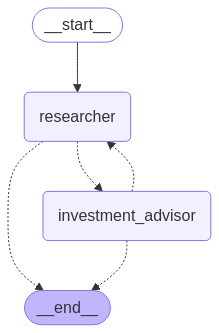

In [78]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
events = graph.stream(
    {
        "messages": [
            ("user", "Given the current market trends and available financial data, what investment strategy would you recommend for a long-term portfolio? Please provide actionable advice.")
        ],
    },
    {"recursion_limit": 150},
)

for event in events:
    print(event)
    print("----")